In [405]:
# plot validation results given dictionary of samples produced using Validation-LEAF-Toolbox.ipynb
#the dictionary keys correspond to GEE feature collections for the original site in-situ data and the
# values corresponds to a list of in-situ samples with available product retrievals

In [57]:
# import packages
import folium
import time
from folium import plugins
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import math 
from sklearn.linear_model import TheilSenRegressor
from numpy import nan
import scipy
import statsmodels.api as sm

In [91]:
# parameters
sampleLAIFileName = "/home/richard_fernandes/validation/LAI7dDictionary0mfil20msam30mbuf.pkl"
samplefCOVERFileName = "/home/richard_fernandes/validation/fCOVER7dDictionary0mfil20msam30mbuf.pkl"
samplefAPARFileName = "/home/richard_fernandes/validation/fAPAR7dDictionary0mfil20msam30mbuf.pkl"

siteFileName = "/home/richard_fernandes/validation/siteSummaries.csv"
variableName = "LAI"
sites_North_America = ['Barrow','BartlettExperimentalForest','BlandyExperimentalFarm','Bondville','Boulder','CentralPlainsExperimentalRange','DeadLake','DesertRock','DesMoines','DisneyWildernessPreserve','DukeForest', \
                        'FortPeck','GoodwinCreek','GuanicaForest','HarvardForest','ImnavaitCreek','JonesEcologicalResearchCenter','Jornada','KonazPrairieBiologicalStation','LajasExperimentalStation','Manhattan','Moab', \
                       'NiwotRidgeForest','NiwotRidgeMountainResearchStation','NorthSterling','OakRidge','OnaquiAult','OrdwaySwisherBiologicalStation','RockSprings','SantaBarbara','SantaRita','SiouxFallsSurfRad',\
                       'SiousFallsUscrn','SmithsonianConservationBiologyInstitute','SmithsonianEnvironmentalResearchCenter','SouthernGreatPlains','StiegerwaldtLandServices','TableMountan',\
                       'TalladegaNationalForest','TonziRanch','Underc','WalnutGulchKendall','Williams','Woodworth','YosemiteVillage', \
                        'Geraldton2020', 'HayRiver2019' ,'Labrador2019' ,'Merbleue2019','MtPolley2019','PeaceRiver2019' ,'TurkeyPoint2019' ,'VancouverIsland2019','YellowKnife2019', 'NovaScotia2021']
treed_IGBP_class = ['Evergreen Broadleaf', 'Evergreen Needleleaf', 'Mixed Forest','Deciduous Broadleaf','Closed Shrublands','Open Shrublands']


In [92]:
# renames columns of in-situ validation samples to standard names
def renameColumns(siteDF) :
    if 'GBOV' in siteDF.name:   
        siteDF['network'] = 'GBOV'
        newNames = {'Site': 'Site', \
                        'FCOVER_down': 'fCOVER_down', \
                        'FCOVER_up': 'fCOVER_up', \
                        'FCOVER_down_err': 'fCOVER_down_err', \
                        'FCOVER_up_err': 'fCOVER_up_err', \
                        'FIPAR_down': 'fAPAR_down', \
                        'FIPAR_up': 'fAPAR_up', \
                        'FIPAR_down_err': 'fAPAR_down_err', \
                        'FIPAR_up_err': 'fAPAR_up_err', \
                        'LAI_Warren_up': 'PAI_up', \
                        'LAI_Warren_down': 'PAI_down', \
                        'LAIe_Warren_up': 'PAIe_up', \
                        'LAIe_Warren_down': 'PAIe_down', \
                        'LAIe_Miller_up': 'PAIe_Miller_up', \
                        'LAIe_Miller_down': 'PAIe_Miller_down', \
                        'LAI_Warren_up_err': 'PAI_up_err', \
                        'LAI_Warren_down_err': 'PAI_down_err', \
                        'LAIe_Warren_up_err': 'PAIe_up_err', \
                        'LAIe_Warren_down_err': 'PAIe_down_err', \
                        'LAIe_Miller_up_err': 'PAIe_Miller_up_err', \
                        'LAIe_Miller_down_err': 'PAIe_Miller_down_err'} 
    elif 'CCRS' in siteDF.name:
        list(siteDF)
        siteDF['network'] = 'CCRS'
        siteDF['IGBP_class'] = 'Mixed Forest'
        siteDF.loc[siteDF['BF']>0.75,'IGBP_class'] = 'Deciduous Broadleaf'
        siteDF.loc[siteDF['BF']<0.25,'IGBP_class'] = 'Evergreen Needleleaf'
        newNames = {'Location': 'Site', \
                    'BF' : 'fBroadleaf' , \
                    'NF': 'fNeedleafleaf' , \
                    'fcover_Down': 'fCOVER_down', \
                    'fcover_Up': 'fCOVER_up', \
                    'fcoverstd_Down': 'fCOVER_down_err', \
                    'fcoverstd_Up': 'fCOVER_up_err', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Up': 'fAPAR_up' , \
                    'Daily_Integrated_Black_Sky_fAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sky_fAPAR_Up': 'fAPAR_up' , \
                    'PAICEV61_Up': 'PAI_up', \
                    'PAICEV61_Down': 'PAI_down', \
                    'PAIeCEV61_Up': 'PAIe_up', \
                    'PAIeCEV61_Down':'PAIe_down', \
                    'PAIEMiller_Up': 'PAIe_Miller_up', \
                    'PAIEMiller_Down':'PAIe_Miller_down', \
                    'Woody_Fraction_average':'WAItoPAIratio', \
                    'Woody_Fraction_std': 'WAItoPAIratio_std' }  
    
    return  siteDF.rename(columns = newNames)


In [93]:
def estimateWAItoPAIratio(samplesDF) :
    #estimate overstory woody to total area ratio for GBOV sites
    # use initial fixed ratio for all sites based on shrubs
    samplesDF.loc[(samplesDF['network'] == 'GBOV') ,'WAItoPAIratio'] = 0.10
    samplesDF.loc[(samplesDF['network'] == 'GBOV') ,'WAItoPAIratio_std'] = 0.11

    # use fixed ratio for needeleaf sites
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio'] = 0.16
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio_std'] = 0.10   
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio'] = 0.16
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio_std'] = 0.10  

    # use fixed ratio for  broadleaf sites
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio'] = 0.24
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio_std'] = 0.11
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio'] = 0.24
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio_std'] = 0.11


    # use fixed ratio for mixed forest
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Mixed Forest'),'WAItoPAIratio'] = 0.18
    samplesDF.loc[(samplesDF['network'] == 'GBOV') & (samplesDF['IGBP_class'] == 'Mixed Forest'),'WAItoPAIratio_std'] = 0.11

    # fix some transcription errors in WAI to PAI ratio for CCRS
    samplesDF['WAItoPAIratio'] = samplesDF['WAItoPAIratio'].clip(lower=0.1,upper=0.24)
    samplesDF['WAItoPAIratio_std'] = samplesDF['WAItoPAIratio_std'].clip(lower=0.1,upper=0.11)
    return (samplesDF)


In [94]:
#calibrating models to estimate insitu error for LAI and LAIe as a function of LAI or LAIe for GBOV
#this is to gap fill missing estimates og insitu error for CCRS plots
with open(samplefCOVERFileName, "rb") as fp:   #Pickling
    sampleDictionary = pickle.load(fp)
samplesfCOVERDF = pd.DataFrame(sampleDictionary['projects/ccmeo-ag-000008/assets/validationGBOV/COPERNICUS_GBOV_RM4_20220616174529']).reset_index(drop=True)
with open(sampleLAIFileName, "rb") as fp:   #Pickling
    sampleDictionary = pickle.load(fp)
samplesLAIDF = pd.DataFrame(sampleDictionary['projects/ccmeo-ag-000008/assets/validationGBOV/COPERNICUS_GBOV_RM7_20220616174529']).reset_index(drop=True)
with open(samplefAPARFileName, "rb") as fp:   #Pickling
    sampleDictionary = pickle.load(fp)
samplesfAPARDF = pd.DataFrame(sampleDictionary['projects/ccmeo-ag-000008/assets/validationGBOV/COPERNICUS_GBOV_RM6_20220616174529']).reset_index(drop=True)
samplesDF = samplesLAIDF.join(samplesfCOVERDF[samplesfCOVERDF.columns.difference(samplesLAIDF.columns)])
samplesDF = samplesDF.join(samplesfAPARDF[samplesfAPARDF.columns.difference(samplesDF.columns)])
samplesDF = samplesDF[samplesDF['IGBP_class'].isin(treed_IGBP_class)]
samplesDF = samplesDF[samplesDF['Site'].isin(sites_North_America)].reset_index()
samplesDF = samplesDF.drop(samplesDF[samplesDF['Elevation'] > 3000].index)
samplesDF[['LAI_Warren_up','LAI_Warren_up_err','LAIe_Warren_up','LAIe_Warren_up_err','FIPAR_down_err','FIPAR_down','FIPAR_up_err','FIPAR_up']] = samplesDF[['LAI_Warren_up','LAI_Warren_up_err','LAIe_Warren_up','LAIe_Warren_up_err','FIPAR_down_err','FIPAR_down','FIPAR_up_err','FIPAR_up']].apply(pd.to_numeric)
samplesDF = samplesDF.replace(-999, 0)
samplesDF = samplesDF[samplesDF['FIPAR_down']<1].reset_index()
samplesDF['FIPAR'] = samplesDF['FIPAR_up'].add((samplesDF['FIPAR_up']).mul(-1).add(1).mul(samplesDF['FIPAR_down'])).add(-0.5).abs()
samplesDF['FIPAR_err'] = samplesDF['FIPAR_up_err'].add((samplesDF['FIPAR_up']).mul(-1).add(1).mul(samplesDF['FIPAR_down_err']))

samplesDFfig1 = samplesDF[['LAI_Warren_up','LAI_Warren_up_err','LAIe_Warren_up','LAIe_Warren_up_err','FIPAR','FIPAR_err','IGBP_class']]
# g = sns.pairplot(samplesDFfig1,hue='IGBP_class')
regLAIeerrvsLAIe = TheilSenRegressor(random_state=0).fit(samplesDF[['LAIe_Warren_up']].values.ravel().reshape(-1, 1), samplesDF[['LAIe_Warren_up_err']].values.ravel())

regLAIerrvsLAI = TheilSenRegressor(random_state=0).fit(samplesDF[['LAI_Warren_up']].values.ravel().reshape(-1, 1), samplesDF[['LAI_Warren_up_err']].values.ravel())
regfAPARerrvsfAPAR = TheilSenRegressor(random_state=0).fit(samplesDF[['FIPAR']].values.ravel().reshape(-1, 1), samplesDF[['FIPAR_err']].values.ravel())
# print(regLAIeerrvsLAIe.coef_,regLAIeerrvsLAIe.intercept_)
# print(regLAIerrvsLAI.coef_,regLAIerrvsLAI.intercept_)
# print(regfAPARerrvsfAPAR.coef_,regfAPARerrvsfAPAR.intercept_)



In [247]:
def parseSampleFile(sampleFileName,variableName):
    #laie err vs laie[0.04830027] 0.002163865830433743
 #lai err vs LAI [0.04480655] 0.010224858872736227
#fapar error vs  fAPAR[0.00798831] 0.0032205732237935323
    # clumping uncertainty
    clumping_err = 0.025
    WAItoPAIdown= 0.1
    
    with open(sampleFileName, "rb") as fp:   #Pickling
        sampleDictionary = pickle.load(fp)
    sitesList = sampleDictionary.keys()
    samplesDF = pd.DataFrame();
    
    for key in sitesList:

        #convert list to pandas data frame, rename columns, filter for North America
        siteDF = pd.concat([pd.DataFrame(sampleDictionary[key]),pd.DataFrame([key] * len(sampleDictionary[key]),columns=['geeFeatureCollection'])],axis=1)
        siteDF.name = key
        siteDF = renameColumns(siteDF)


        siteDF = siteDF[siteDF['IGBP_class'].isin(treed_IGBP_class)]
        siteDF = siteDF[siteDF['Site'].isin(sites_North_America)].reset_index()
        #number of samples and number valid samples
        numValid = []
        numSamples = []
        list(siteDF)

        for index,site in siteDF.iterrows():
            siteQC = site['sample'+variableName][1]['data']
            numSamples.append(len(siteQC))
            numValid.append(len(siteQC) - np.count_nonzero(siteQC))
        numSamplesDF= pd.DataFrame(numSamples,columns=['numSamples'])
        numValidDF = pd.DataFrame(numValid,columns=['numValid'])
        siteDF = pd.concat([siteDF,numSamplesDF, numValidDF],axis=1)
        samplesDF = pd.concat([samplesDF,siteDF],axis=0,ignore_index=True)
    
    samplesDF = samplesDF.reset_index(drop=True)
    if variableName == 'LAI' :
        
        
        samplesDF[['PAI_up','PAI_down','PAIe_up','PAIe_down','PAI_up_err','PAI_down_err','PAIe_up_err','PAIe_down_err']] = samplesDF[['PAI_up','PAI_down','PAIe_up','PAIe_down','PAI_up_err','PAI_down_err','PAIe_up_err','PAIe_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)

        # gap fill estimates of insitu error for CCRS
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_up'].mul(0.04830027).add(0.002163865830433743)
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_down'].mul(0.04830027).add(0.002163865830433743)        
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_up'].mul(0.04480655).add(0.010224858872736227)
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_down'].mul(0.04480655).add(0.010224858872736227)

        
        samplesDF['percentValid'] = samplesDF['numValid'].div(samplesDF['numSamples'])
        
        # add error due to uncertainty in clumping
        samplesDF['PAI_up_err_clumping'] = samplesDF['PAI_up'].mul(samplesDF['PAI_up'].div((samplesDF['PAIe_up']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_up_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_up_err_clumping'].pow(2)).pow(0.5)
        samplesDF['PAI_down_err_clumping'] = samplesDF['PAI_down'].mul(samplesDF['PAI_down'].div((samplesDF['PAIe_down']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_down_err'] = samplesDF['PAI_down_err'].pow(2).add(samplesDF['PAI_down_err_clumping'].pow(2)).pow(0.5)

        #compute total canopy values including woody area
        samplesDF['PAI_total'] = samplesDF['PAI_up'].add(samplesDF['PAI_down']) 
        samplesDF['PAI_total_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_down_err'].pow(2)).pow(0.5)
        samplesDF['PAIe_total'] = samplesDF['PAIe_up'].add(samplesDF['PAIe_down']) 
        samplesDF['PAIe_total_err'] = samplesDF['PAIe_up_err'].pow(2).add(samplesDF['PAIe_down_err'].pow(2)).pow(0.5)
        samplesDF['clumping_total'] = samplesDF['PAIe_total'].div(samplesDF['PAI_total'] ) 
        samplesDF['clumping_total_err']  = (2 * clumping_err  * clumping_err) ** (0.5)          
         #compute total canopy values depending to removing woddy area
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF['LAI_up'] = samplesDF['PAI_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_up_err'] = samplesDF['PAI_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_down'] = samplesDF['PAI_down'] * ( 1 - WAItoPAIdown)
        samplesDF['LAI_down_err'] = samplesDF['PAI_down_err'] * ( 1 - WAItoPAIdown)
        samplesDF['LAI_total'] = samplesDF['LAI_up'] + samplesDF['LAI_down']
        samplesDF['LAI_total_err'] = samplesDF['LAI_down_err'].pow(2).add(samplesDF['LAI_up_err'].pow(2)).pow(0.5)                                                                           
        samplesDF['LAIe_up'] = samplesDF['PAIe_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_up_err'] = samplesDF['PAIe_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_down'] = samplesDF['PAIe_down'] * ( 1 - WAItoPAIdown)
        samplesDF['LAIe_down_err'] = samplesDF['PAIe_down_err'] * ( 1 - WAItoPAIdown)
        samplesDF['LAIe_total'] = samplesDF['LAIe_up'] + samplesDF['LAIe_down']
        samplesDF['LAIe_total_err'] = samplesDF['LAIe_down_err'].pow(2).add(samplesDF['LAIe_up_err'].pow(2)).add(samplesDF['LAI_up'].mul(samplesDF['LAI_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)                                                             
    elif variableName == 'fCOVER' :
        samplesDF.loc[[729],'fCOVER_down']=0
        samplesDF.loc[[730],'fCOVER_down_err']=0
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF[['fCOVER_up','fCOVER_down','fCOVER_up_err','fCOVER_down_err']] = samplesDF[['fCOVER_up','fCOVER_down','fCOVER_up_err','fCOVER_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)
        samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']
        samplesDF['fCOVER_up'] = samplesDF['fCOVER_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fCOVER_down'] = samplesDF['fCOVER_down'] * ( 1 - WAItoPAIdown)
        samplesDF['fCOVER_total'] = samplesDF['fCOVER_up'].add((samplesDF['fCOVER_up'].mul(-1).add(1)).mul(samplesDF['fCOVER_down'] ))
        samplesDF['fCOVER_total_err'] = samplesDF['fCOVER_down_err'].pow(2).add(samplesDF['fCOVER_up_err'].pow(2)).add(samplesDF['fCOVER_up'].mul(samplesDF['fCOVER_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  
    elif  variableName == 'fAPAR' :
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF[['fAPAR_up','fAPAR_down','fAPAR_up_err','fAPAR_down_err']] = samplesDF[['fAPAR_up','fAPAR_down','fAPAR_up_err','fAPAR_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)
        samplesDF['fAPAR_up'] = samplesDF['fAPAR_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fAPAR_down'] = samplesDF['fAPAR_down'] * ( 1 - WAItoPAIdown)
        samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']
        samplesDF['fAPAR_total'] = samplesDF['fAPAR_up'].add((samplesDF['fAPAR_up'].mul(-1).add(1)).mul(samplesDF['fAPAR_down'] ))
        # gap fill estimates of insitu error for CCRS
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        samplesDF['fAPAR_total_err'] = samplesDF['fAPAR_down_err'].pow(2).add(samplesDF['fAPAR_up_err'].pow(2)).add(samplesDF['fAPAR_up'].mul(samplesDF['fAPAR_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  
    else :
        print('variable not found')
              
    return(samplesDF)
                                                                                                                                    



In [120]:
# compute residuals
def summaryStats(samplesDF,samplesLAIDF,xvariable,yvariable,trimquantile,minPAI):
    estimateMedian = [] 
    estimateSTD = [] 
    medianError = [] 
    estimateCount = [] 
    samplesDF = samplesDF.join(samplesLAIDF[samplesLAIDF.columns.difference(samplesDF.columns)])
    samplesDF = pd.concat([samplesDF.loc[samplesDF['network']=='CCRS'],samplesDF.loc[(samplesDF['PAI_total']>minPAI) & (samplesDF['network']=='GBOV')]],axis=0)
    for index, sample in samplesDF.iterrows():
        reference = sample[yvariable]
        qc = sample['sample'+xvariable][1]['data']
        estimate = sample['sample'+xvariable][2]['data']
        error = sample['sample'+xvariable][5]['data']
        productDF = pd.DataFrame(list(zip(qc,estimate,error)),columns=['qc','estimate','error'])
        productDF = productDF.loc[productDF['qc']==0]
        if productDF.shape[0]>0 :
            productDF['absresidual'] = (productDF['estimate'] - reference).abs()
            quantileResidual = productDF['absresidual'].quantile(trimquantile/100,interpolation='nearest')
            estimateMedian.append(productDF.loc[productDF['absresidual']==quantileResidual]['estimate'].mean())
            estimateSTD.append(productDF.loc[productDF['absresidual']<=quantileResidual,['estimate']].std().divide((productDF.loc[productDF['absresidual']<=quantileResidual].shape[0]) ** (0.5)))
            medianError.append(productDF.loc[productDF['absresidual']==quantileResidual]['error'].median())
            estimateCount.append(productDF.loc[productDF['absresidual']<=quantileResidual].shape[0])
        else:
            estimateMedian.append(nan)
            estimateSTD.append(nan)
            medianError.append(nan)
            estimateCount.append(0)
    samplesDF[xvariable+'_'+yvariable+'_estimate'] = estimateMedian
    samplesDF[xvariable+'_'+yvariable+'_estimate_std'] = estimateSTD 
    samplesDF[xvariable+'_'+yvariable+'_err_estimate_mean'] = medianError
    samplesDF[xvariable+'_'+yvariable+'_estimate_count'] = estimateCount
    return(samplesDF)

In [241]:
# get summary stats
samplesList = []
samplesLAIeU = []
samplesLAIU = []
samplesfAPARU = []
samplesfCOVERU = []

samplesLAIeU5 = []
samplesLAIU5 = []
samplesfAPARU5 = []
samplesfCOVERU5 = []

samplesLAIeU50 = []
samplesLAIU50 = []
samplesfAPARU50 = []
samplesfCOVERU50 = []

samplesLAIeU95 = []
samplesLAIU95 = []
samplesfAPARU95 = []
samplesfCOVERU95 = []
for p in range(10,110,10):
    print(p)
    
    samplesLAIDF = summaryStats(parseSampleFile(sampleLAIFileName,'LAI'),parseSampleFile(sampleLAIFileName,'LAI'),'LAI','PAIe_total',p,0.01).reset_index(drop=True) #.drop(['fCOVER_up','fCOVER_down','fAPAR_up','fAPAR_down','fCOVER_up_std','fCOVER_down_std','fAPAR_up_std','fAPAR_down_std'],axis=1)
    samplesfAPARDF = summaryStats(parseSampleFile(samplefAPARFileName,'fAPAR'),parseSampleFile(sampleLAIFileName,'LAI'),'fAPAR','fAPAR_total',p,0.01).reset_index(drop=True) #.drop(['fAPAR_up','fAPAR_down','fAPAR_up_std','fAPAR_down_std'],axis=1)
    samplesfCOVERDF = summaryStats(parseSampleFile(samplefCOVERFileName,'fCOVER'),parseSampleFile(sampleLAIFileName,'LAI'),'fCOVER','fCOVER_total',p,0.01).reset_index(drop=True)

    samplesDF = samplesfAPARDF[['fAPAR_up','fAPAR_down','fAPAR_total','fAPAR_up_err','fAPAR_down_err','fAPAR_total_err','samplefAPAR','fAPAR_fAPAR_total_estimate','fAPAR_fAPAR_total_estimate_std','fAPAR_fAPAR_total_err_estimate_mean','fAPAR_fAPAR_total_estimate_count']] \
                .join(samplesfCOVERDF[['fCOVER_up','fCOVER_down','fCOVER_total','fCOVER_up_err','fCOVER_down_err','fCOVER_total_err','samplefCOVER','fCOVER_fCOVER_total_estimate','fCOVER_fCOVER_total_estimate_std','fCOVER_fCOVER_total_err_estimate_mean','fCOVER_fCOVER_total_estimate_count']])
    

    samplesDF = samplesDF.join(samplesLAIDF[samplesLAIDF.columns.difference(samplesDF.columns)])
    
    samplesDF = samplesDF[samplesDF['LAI_PAIe_total_estimate_count']>0]
    samplesDF = samplesDF.dropna(subset='fAPAR_fAPAR_total_estimate')
    samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total_err'].mul(0.5) \
                                    .add(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'].mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total_err'].divide(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total'])).mul(0.25))
    samplesDF.loc[samplesDF['network'] == 'CCRS','LAI_total_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','LAI_total_err'].mul(0.5) \
                                    .add(samplesDF.loc[samplesDF['network'] == 'CCRS','LAI_total'].mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total_err'].divide(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total'])).mul(0.25))
    samplesDF.loc[samplesDF['network'] == 'CCRS','LAIe_total_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','LAIe_total_err'].mul(0.5) \
                                    .add(samplesDF.loc[samplesDF['network'] == 'CCRS','LAIe_total'].mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total_err'].divide(samplesDF.loc[samplesDF['network'] == 'CCRS','fCOVER_total'])).mul(0.25))
    samplesDF = samplesDF.drop(samplesDF[samplesDF['Elevation'] > 3000].index)

    
    samplesList.append(samplesDF)


    samplesLAIeU95.append(samplesDF['LAIe_total'].sub(samplesDF['LAI_PAIe_total_estimate']).abs().quantile(0.95) )
    samplesLAIU95.append(samplesDF['LAI_total'].sub(samplesDF['LAI_PAIe_total_estimate']).abs().quantile(0.95) )
    samplesfAPARU95.append(samplesDF['fAPAR_total'].sub(samplesDF['fAPAR_fAPAR_total_estimate']).abs().quantile(0.95) )
    samplesfCOVERU95.append(samplesDF['fCOVER_total'].sub(samplesDF['fCOVER_fCOVER_total_estimate']).abs().quantile(0.95) )
    

    samplesLAIeU50.append(samplesDF['LAIe_total'].sub(samplesDF['LAI_PAIe_total_estimate']).abs().quantile(0.5) )
    samplesLAIU50.append(samplesDF['LAI_total'].sub(samplesDF['LAI_PAIe_total_estimate']).abs().quantile(0.5) )
    samplesfAPARU50.append(samplesDF['fAPAR_total'].sub(samplesDF['fAPAR_fAPAR_total_estimate']).abs().quantile(0.5) )
    samplesfCOVERU50.append(samplesDF['fCOVER_total'].sub(samplesDF['fCOVER_fCOVER_total_estimate']).abs().quantile(0.5) )
    
    samplesLAIeU5.append(samplesDF['LAIe_total'].sub(samplesDF['LAI_PAIe_total_estimate']).abs().quantile(0.05) )
    samplesLAIU5.append(samplesDF['LAI_total'].sub(samplesDF['LAI_PAIe_total_estimate']).abs().quantile(0.05) )
    samplesfAPARU5.append(samplesDF['fAPAR_total'].sub(samplesDF['fAPAR_fAPAR_total_estimate']).abs().quantile(0.05) )
    samplesfCOVERU5.append(samplesDF['fCOVER_total'].sub(samplesDF['fCOVER_fCOVER_total_estimate']).abs().quantile(0.05) )

10
20
30
40
50
60
70
80
90
100


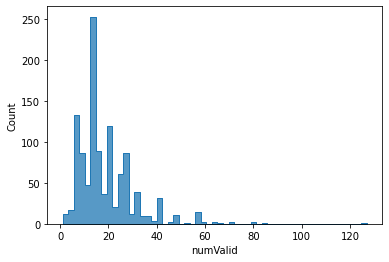

In [122]:
# number of valid samples per plot
fig,ax = plt.subplots()
sns.histplot(samplesList[9], x='numValid',element="step")
plt.show()

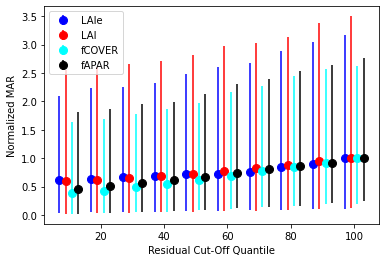

In [242]:
# figure backup 1
# compares residuals as a function of quartile threshold used for selecting valid retrievals
x = np.array(range(10,110,10))
LAIeU50 = np.array(samplesLAIeU50)
LAIeU5 = np.array(samplesLAIeU50) - np.array(samplesLAIeU5) 
LAIeU95 = np.array(samplesLAIeU95) - np.array(samplesLAIeU50)

LAIU50 = np.array(samplesLAIU50)
LAIU5 = np.array(samplesLAIU50) - np.array(samplesLAIU5) 
LAIU95 = np.array(samplesLAIU95) - np.array(samplesLAIU50)

fCOVERU50 = np.array(samplesfCOVERU50)
fCOVERU5 = np.array(samplesfCOVERU50) - np.array(samplesfCOVERU5) 
fCOVERU95 = np.array(samplesfCOVERU95) - np.array(samplesfCOVERU50)

fAPARU50 = np.array(samplesfAPARU50)
fAPARU5 = np.array(samplesfAPARU50) - np.array(samplesfAPARU5) 
fAPARU95 = np.array(samplesfAPARU95) - np.array(samplesfAPARU50)

plt.errorbar(x-3, LAIeU50/LAIeU50[9],yerr=np.column_stack((LAIeU5/LAIeU50[9],LAIeU95/LAIeU50[9])).transpose(), ecolor='blue', marker='o', mfc='blue', mec='blue', ms=8, ls = 'none',label='LAIe')
plt.errorbar(x-1, LAIU50/LAIU50[9],yerr=np.column_stack((LAIU5/LAIU50[9],LAIU95/LAIU50[9])).transpose(), ecolor='red', marker='o', mfc='red', mec='red', ms=8, ls = 'none',label='LAI')
plt.errorbar(x+1, fCOVERU50/fCOVERU50[9],yerr=np.column_stack((fCOVERU5/fCOVERU50[9],fCOVERU95/fCOVERU50[9])).transpose(), ecolor='cyan',marker='o', mfc='cyan', mec='cyan', ms=8, ls = 'none',label='fCOVER')
plt.errorbar(x+3, fAPARU50/fAPARU50[9],yerr=np.column_stack((fAPARU5/fAPARU50[9],fAPARU95/fAPARU50[9])).transpose(), ecolor = 'black', marker='o', mfc='black', mec='black', ms=8, ls = 'none',label='fAPAR')
plt.xlabel('Residual Cut-Off Quantile')
plt.ylabel('Normalized MAR')
plt.legend(loc='upper left')



plt.show()

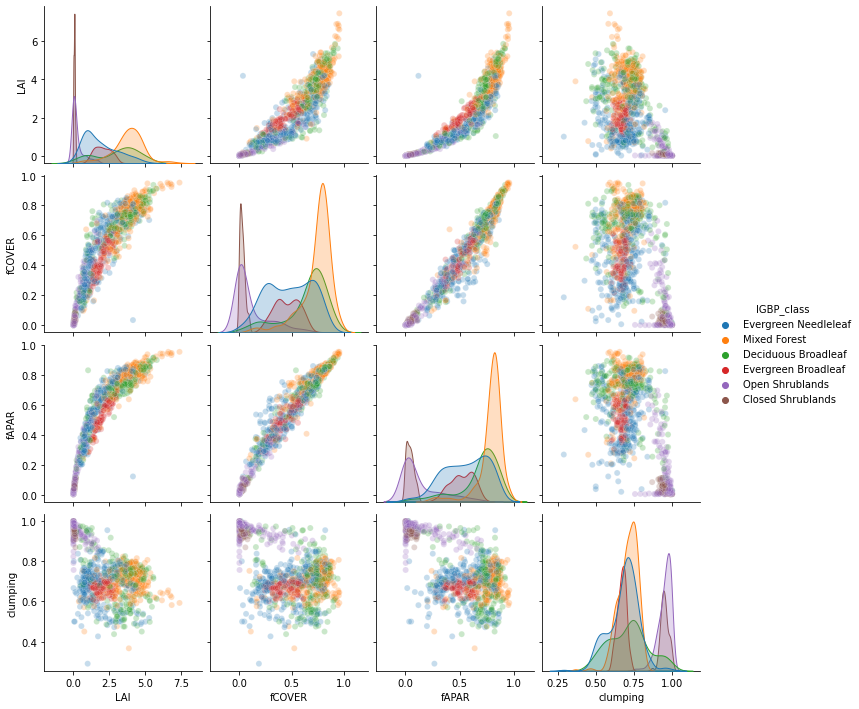

In [124]:
# figure 2a  reference variables by IGBP
samplesDF = samplesList[4].rename(columns={'LAI_total':'LAI','fCOVER_total':'fCOVER','fAPAR_total':'fAPAR','clumping_total':'clumping',})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','clumping','IGBP_class']]
g = sns.pairplot(samplesDFfig1, hue='IGBP_class', markers= 'o',plot_kws={'alpha': 0.25})
plt.savefig('figure3a.png') 

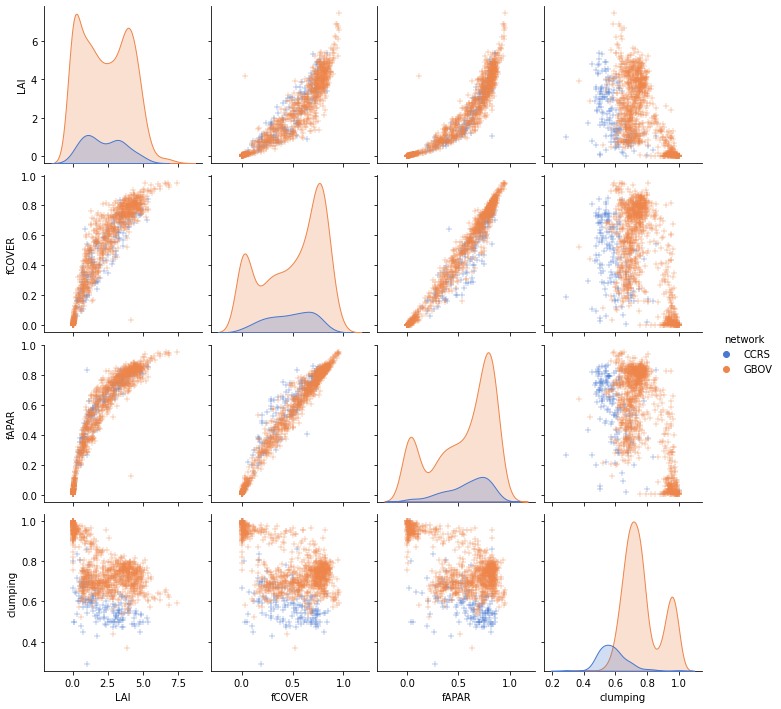

In [125]:
# figure 2b  reference variables by network
samplesDF = samplesList[4].rename(columns={'LAI_total':'LAI','fCOVER_total':'fCOVER','fAPAR_total':'fAPAR','clumping_total':'clumping',})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','clumping','network']]
g = sns.pairplot(samplesDFfig1, hue='network', markers= '+',plot_kws={'alpha': 0.75},palette='muted')
plt.savefig('Figure3b.png')

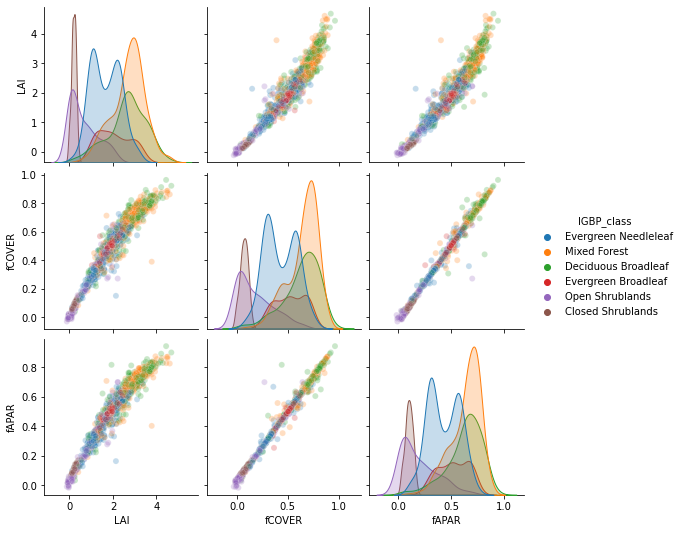

In [243]:
# figure 3a sl2p variables by IGBP
samplesDF = samplesList[4].rename(columns={'LAI_PAIe_total_estimate':'LAI','fCOVER_fCOVER_total_estimate':'fCOVER','fAPAR_fAPAR_total_estimate':'fAPAR'})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','IGBP_class']]
g = sns.pairplot(samplesDFfig1, hue='IGBP_class', markers= 'o',plot_kws={'alpha': 0.25})
plt.savefig('xFigure4a.png')

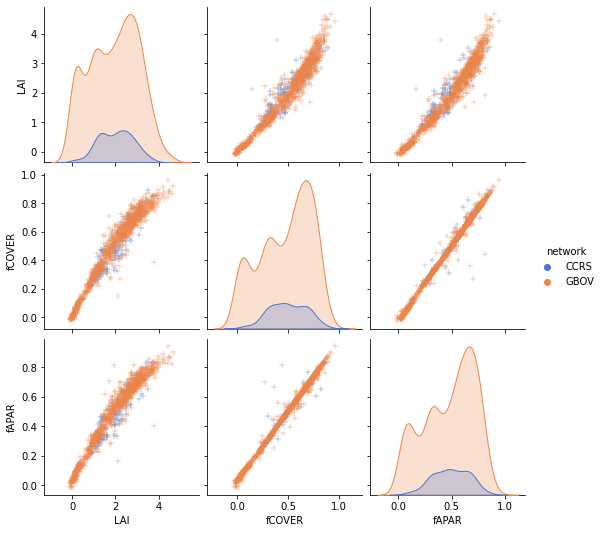

In [244]:
# figure 3b sl2p variables by network
samplesDF = samplesList[4].rename(columns={'LAI_PAIe_total_estimate':'LAI','fCOVER_fCOVER_total_estimate':'fCOVER','fAPAR_fAPAR_total_estimate':'fAPAR',})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','network']]
g = sns.pairplot(samplesDFfig1, hue='network', markers= '+',plot_kws={'alpha': 0.75},palette='muted')
plt.savefig('xFigure4b.png')

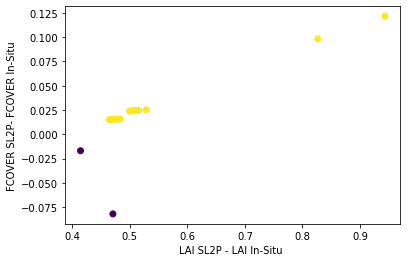

In [245]:
k=100
sampleDF = samplesList[9].reset_index()
esuDF = samplesDF.iloc[k]
noise = 1+np.random.normal(0,0.025,len(esuDF['sampleLAI'][2]['data']))
# print(samplesDF[samplesDF['numValid']>100])
fig,ax = plt.subplots()
#sns.scatterplot( x=esuDF['sampleLAI'][3]['data'], y=esuDF['samplefAPAR'][3]['data'], hue=esuDF['sampleLAI'][0]['data'],  alpha=.5, palette="muted", ax=ax[0,1],legend=True)
plt.scatter((esuDF['sampleLAI'][2]['data']-esuDF['LAI_total'])*noise,(esuDF['samplefCOVER'][2]['data']-esuDF['fCOVER_total'])*noise,c=esuDF['sampleLAI'][0]['data'])
plt.xlabel('LAI SL2P - LAI In-Situ ')
plt.ylabel('FCOVER SL2P- FCOVER In-Situ')
plt.savefig('Figure11.png',bbox_inches='tight')
plt.show()

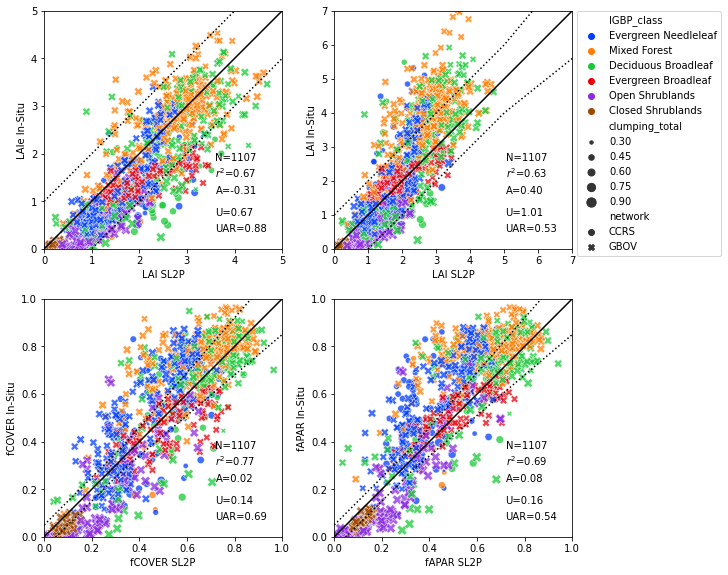

In [246]:
# figure 4

fig, ax = plt.subplots(2,2,constrained_layout = True)
fig.set_size_inches(10 ,8)
data = samplesList[4]


y = data['LAIe_total']
yerror = data['LAIe_total_err']
x = data['LAI_PAIe_total_estimate']
xerror = data['LAI_PAIe_total_err_estimate_mean'].astype('float')
# ax[0,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAIe_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=0.75,palette="bright", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.maximum(np.linspace(0,6,100)*0.20,1),color='black',linestyle='dotted')
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.minimum(-np.linspace(0,6,100)*0.20,-1),color='black',linestyle='dotted')
ax[0,0].plot([0,6],[0,6],color='black')
ax[0,0].set(adjustable='box',aspect='equal')
ax[0,0].set_ylabel('LAIe In-Situ')
ax[0,0].set_xlabel('LAI SL2P')
n = len(x)
res = np.array(y.sub(x))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(res<np.maximum(0.05,0.15*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[0,0].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[0,0].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[0,0].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[0,0].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[0,0].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

y = data['LAI_total']
yerror = data['LAI_total_err']
x = data['LAI_PAIe_total_estimate']
xerror = data['LAI_PAIe_total_err_estimate_mean'].astype('float')
# ax[0,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAI_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[0,1])
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.maximum(np.linspace(0,7,100)*0.20,1),color='black',linestyle='dotted')
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.minimum(-np.linspace(0,7,100)*0.20,-1),color='black',linestyle='dotted')
ax[0,1].plot([0,7],[0,7],color='black')
ax[0,1].set(adjustable='box',aspect='equal')
ax[0,1].set_ylabel('LAI In-Situ')
ax[0,1].set_xlabel('LAI SL2P')
n = len(x)
res = np.array(y.sub(x))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(res<np.maximum(0.05,0.15*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[0,1].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[0,1].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[0,1].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[0,1].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[0,1].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

y = data['fCOVER_total']
yerror = data['fCOVER_total_err']
x = data['fCOVER_fCOVER_total_estimate']
xerror = data['fCOVER_fCOVER_total_err_estimate_mean'].astype('float')
# ax[1,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.scatterplot(data=data, x='fCOVER_fCOVER_total_estimate', y='fCOVER_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.15,0.05),color='black',linestyle='dotted')
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='black',linestyle='dotted')
ax[1,0].plot([0,1],[0,1],color='black')
ax[1,0].set(adjustable='box',aspect='equal')
ax[1,0].set_ylabel('fCOVER In-Situ')
ax[1,0].set_xlabel('fCOVER SL2P')
n = len(x)
res = np.array(y.sub(x))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(res<np.maximum(0.05,0.15*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[1,0].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[1,0].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[1,0].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[1,0].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[1,0].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

y = data['fAPAR_total']
yerror = data['fAPAR_total_err']
x = data['fAPAR_fAPAR_total_estimate']
xerror = data['fAPAR_fAPAR_total_err_estimate_mean'].astype('float')
# ax[1,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
sns.scatterplot(data=data, x='fAPAR_fAPAR_total_estimate', y='fAPAR_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.15,0.05),color='black',linestyle='dotted')
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='black',linestyle='dotted')
ax[1,1].plot([0,1],[0,1],color='black')
ax[1,1].set(adjustable='box',aspect='equal')
ax[1,1].set_ylabel('fAPAR In-Situ')
ax[1,1].set_xlabel('fAPAR SL2P')
n = len(x)
res = np.array(y.sub(x))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(res<np.maximum(0.05,0.15*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[1,1].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[1,1].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[1,1].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[1,1].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[1,1].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

ax[0,0].set_xlim([0,5])
ax[0,1].set_xlim([0,7])
ax[1,0].set_xlim([0,1])
ax[1,1].set_xlim([0,1])
ax[0,0].set_ylim([0,5])
ax[0,1].set_ylim([0,7])
ax[1,0].set_ylim([0,1])
ax[1,1].set_ylim([0,1])
plt.savefig('xFigure6.png',bbox_inches='tight')
plt.show()


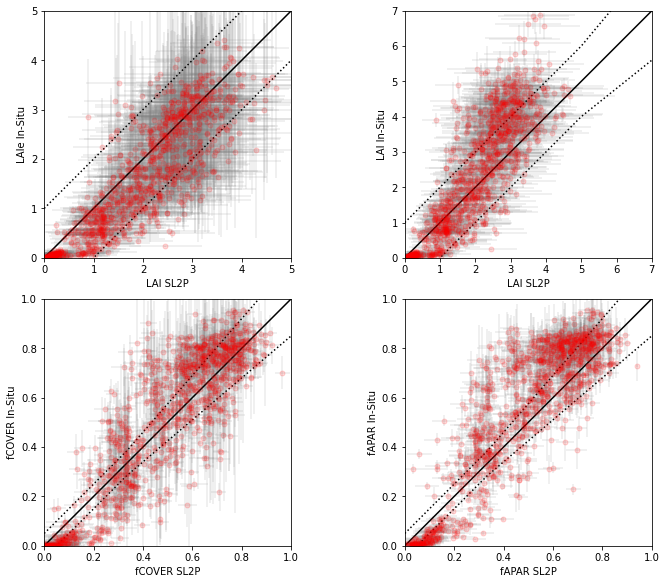

In [171]:
# figure 6

fig, ax = plt.subplots(2,2,constrained_layout = True)
fig.set_size_inches(10 ,8)
data = samplesList[4]


y = data['LAIe_total']
yerror = data['LAIe_total_err']
x = data['LAI_PAIe_total_estimate']
xerror = ((data['LAI_PAIe_total_estimate_std'].astype('float')).pow(2).add(data['LAI_PAIe_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[0,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=5, ecolor='grey',alpha=0.15)
#sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAIe_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=0.75,palette="bright", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.maximum(np.linspace(0,6,100)*0.20,1),color='black',linestyle='dotted')
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.minimum(-np.linspace(0,6,100)*0.20,-1),color='black',linestyle='dotted')
ax[0,0].plot([0,6],[0,6],color='black')
ax[0,0].set(adjustable='box',aspect='equal')
ax[0,0].set_ylabel('LAIe In-Situ')
ax[0,0].set_xlabel('LAI SL2P')


y = data['LAI_total']
yerror = data['LAI_total_err']
x = data['LAI_PAIe_total_estimate']
xerror = ((data['LAI_PAIe_total_estimate_std'].astype('float')).pow(2).add(data['LAI_PAIe_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[0,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=5, ecolor='grey',alpha=0.15)
#sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAI_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[0,1])
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.maximum(np.linspace(0,7,100)*0.20,1),color='black',linestyle='dotted')
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.minimum(-np.linspace(0,7,100)*0.20,-1),color='black',linestyle='dotted')
ax[0,1].plot([0,7],[0,7],color='black')
ax[0,1].set(adjustable='box',aspect='equal')
ax[0,1].set_ylabel('LAI In-Situ')
ax[0,1].set_xlabel('LAI SL2P')

y = data['fCOVER_total']
yerror = data['fCOVER_total_err']
x = data['fCOVER_fCOVER_total_estimate']
xerror = ((data['fCOVER_fCOVER_total_estimate_std'].astype('float')).pow(2).add(data['fCOVER_fCOVER_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[1,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=5, ecolor='grey',alpha=0.15)
# ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#sns.scatterplot(data=data, x='fCOVER_fCOVER_total_estimate', y='fCOVER_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.15,0.05),color='black',linestyle='dotted')
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='black',linestyle='dotted')
ax[1,0].plot([0,1],[0,1],color='black')
ax[1,0].set(adjustable='box',aspect='equal')
ax[1,0].set_ylabel('fCOVER In-Situ')
ax[1,0].set_xlabel('fCOVER SL2P')

y = data['fAPAR_total']
yerror = data['fAPAR_total_err']
x = data['fAPAR_fAPAR_total_estimate']
xerror = ((data['fAPAR_fAPAR_total_estimate_std'].astype('float')).pow(2).add(data['fAPAR_fAPAR_total_err_estimate_mean'].astype('float').pow(2))).pow(0.5)
ax[1,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=5, ecolor='grey',alpha=0.15)
#sns.scatterplot(data=data, x='fAPAR_fAPAR_total_estimate', y='fAPAR_total', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.15,0.05),color='black',linestyle='dotted')
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='black',linestyle='dotted')
ax[1,1].plot([0,1],[0,1],color='black')
ax[1,1].set(adjustable='box',aspect='equal')
ax[1,1].set_ylabel('fAPAR In-Situ')
ax[1,1].set_xlabel('fAPAR SL2P')

ax[0,0].set_xlim([0,5])
ax[0,1].set_xlim([0,7])
ax[1,0].set_xlim([0,1])
ax[1,1].set_xlim([0,1])
ax[0,0].set_ylim([0,5])
ax[0,1].set_ylim([0,7])
ax[1,0].set_ylim([0,1])
ax[1,1].set_ylim([0,1])
plt.savefig('Figure7.png',bbox_inches='tight')
plt.show()
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# data = samplesU50DF[samplesU50DF['network']=='GBOV']
# sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAI_total', hue='IGBP_class',ax=ax)


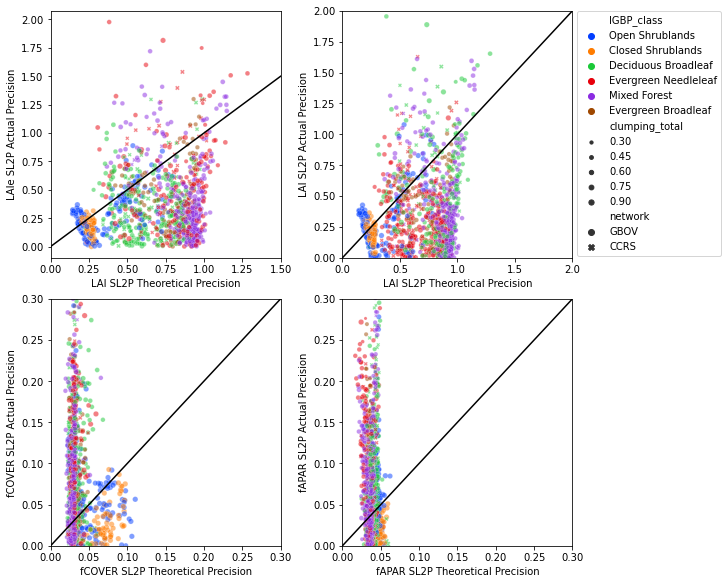

In [172]:
# figure 5
import numpy.polynomial.chebyshev as cheb
fig, ax = plt.subplots(2, 2,constrained_layout = True)
fig.set_size_inches(10, 8)

percentileToPlot = 4

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAIe_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])

data['LAIe_precision'] = pre
sns.scatterplot(data=data, x='LAI_PAIe_total_err_estimate_mean', y='LAIe_precision', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 30), alpha=.5, palette="bright", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,1.5,100),np.linspace(0,1.5,100),color='black')
ax[0,1].set_ylim([0,1.5])
ax[0,0].set_xlim([0,1.5])
ax[0,0].set_ylabel('LAIe SL2P Actual Precision')
ax[0,0].set_xlabel('LAI SL2P Theoretical Precision')


#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])

data['LAI_precision'] = pre
sns.scatterplot(data=data, x='LAI_PAIe_total_err_estimate_mean', y='LAI_precision', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 30), alpha=.5, palette="bright", ax=ax[0,1],legend=True)
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax[0,1].plot(np.linspace(0,2,100),np.linspace(0,2,100),color='black')
ax[0,1].set_ylim([0,2])
ax[0,1].set_xlim([0,2])
ax[0,1].set_ylabel('LAI SL2P Actual Precision')
ax[0,1].set_xlabel('LAI SL2P Theoretical Precision')


#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])
data['fCOVER_precision']=pre

sns.scatterplot(data=data, x='fCOVER_fCOVER_total_err_estimate_mean', y='fCOVER_precision', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(10, 30), alpha=.5, palette="bright", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,.3,100),np.linspace(0,.3,100),color='black')
ax[1,0].set_ylim([0,.3])
ax[1,0].set_xlim([0,.3])
ax[1,0].set_ylabel('fCOVER SL2P Actual Precision')
ax[1,0].set_xlabel('fCOVER SL2P Theoretical Precision')
#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])


data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])

y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
accCheb= cheb.Chebyshev.fit(x, y,3,window=[np.amin(x), np.amax(x)])
unc = abs(y)
uncCheb= cheb.Chebyshev.fit(x,unc,3,window=[np.amin(x), np.amax(x)])
pre = abs(y-(cheb.chebval(x,accCheb.coef)))
preCheb= cheb.Chebyshev.fit(x, pre,3,window=[np.amin(x), np.amax(x)])
data['fAPAR_precision'] = pre


sns.scatterplot(data=data, x='fAPAR_fAPAR_total_err_estimate_mean', y='fAPAR_precision', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(5,30), alpha=.5, palette="bright", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,.3,100),np.linspace(0,.3,100),color='black')
ax[1,1].set_ylim([0,.3])
ax[1,1].set_xlim([0,.3])
ax[1,1].set_ylabel('fAPAR SL2P Actual Precision')
ax[1,1].set_xlabel('fAPAR SL2P Theoretical Precision')
plt.savefig('Figure9.png',bbox_inches='tight')


In [228]:
def plotSummaryStats(x,y,err,axis,degree):

    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree = degree)
    xp = poly.fit_transform(x.reshape(-1,1))
    accSummary = sm.WLS(y, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    pre = abs(y-np.array(accSummary['mean']))
    preSummary = sm.WLS(pre, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    unc = abs(y)
    print(sm.WLS(y, xp, err ** (-2)).fit().summary())
    print(sm.WLS(pre, xp, err ** (-2)).fit().summary())
    uncSummary = sm.WLS(unc, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    axis.plot(x, accSummary['mean'], color='darkgreen', label='Accuracy')
    axis.plot(x, accSummary['mean_ci_upper'], color='darkgreen',linewidth=0.5,linestyle='--')
    axis.plot(x, accSummary['mean_ci_lower'],color='darkgreen',linewidth=0.5,linestyle='--')
    axis.plot(x, preSummary['mean'], color='darkorange', label='Precision')
    axis.plot(x, preSummary['mean_ci_upper'], color='darkorange',linewidth=0.5,linestyle='--')
    axis.plot(x, preSummary['mean_ci_lower'],color='darkorange',linewidth=0.5,linestyle='--')
    axis.plot(x, (accSummary['mean'].pow(2).add(preSummary['mean'].pow(2)).pow(0.5)), color = 'royalblue', label='Uncertainty')
    axis.plot(x, uncSummary['mean_ci_upper'].sub(uncSummary['mean']).add((accSummary['mean'].pow(2).add(preSummary['mean'].pow(2)).pow(0.5))), color = 'royalblue',linewidth=0.5,linestyle='--')
    axis.plot(x, uncSummary['mean_ci_lower'].sub(uncSummary['mean']).add((accSummary['mean'].pow(2).add(preSummary['mean'].pow(2)).pow(0.5))),color = 'royalblue',linewidth=0.5,linestyle='--')

    return

In [224]:
def plotUncertainty(x,y,err,axis,degree,color,label):

    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree = degree)
    xp = poly.fit_transform(x.reshape(-1,1))
    accSummary = sm.WLS(y, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    pre = abs(y-np.array(accSummary['mean']))
    preSummary = sm.WLS(pre, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    unc = abs(y)
    uncSummary = sm.WLS(unc, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    axis.plot(x, (accSummary['mean'].pow(2).add(preSummary['mean'].pow(2)).pow(0.5)), color = color, label=label)
    axis.plot(x, uncSummary['mean_ci_upper'].sub(uncSummary['mean']).add((accSummary['mean'].pow(2).add(preSummary['mean'].pow(2)).pow(0.5))), color = color,label='+/- 95% c.i.',linewidth=0.5,linestyle='--')
    axis.plot(x, uncSummary['mean_ci_lower'].sub(uncSummary['mean']).add((accSummary['mean'].pow(2).add(preSummary['mean'].pow(2)).pow(0.5))),color = color,linewidth=0.5,linestyle='--')


    return

AttributeError: 'DataFrame' object has no attribute 'summary'

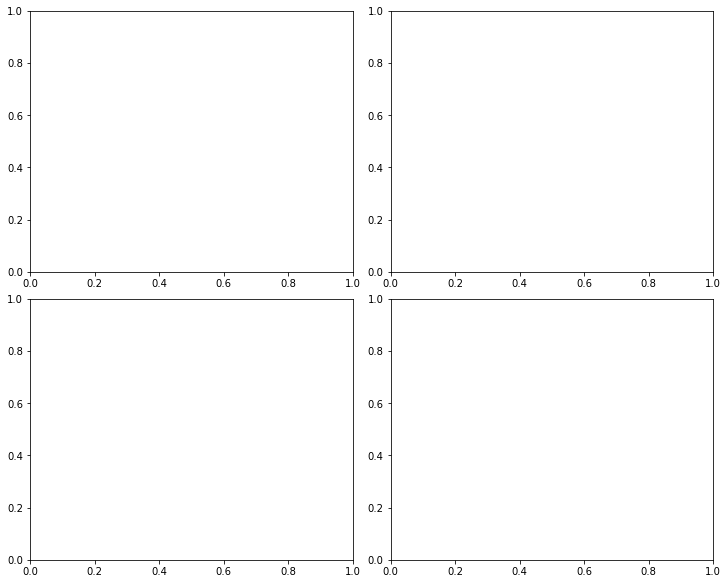

In [225]:
# figure 5


fig, ax = plt.subplots(2, 2,constrained_layout = True)
fig.set_size_inches(10, 8)

percentileToPlot = 4

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAIe_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
plotSummaryStats(x,y,err,ax[0,0],3)
sns.scatterplot(data=data, x='LAIe_total', y='LAIe_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,4,100),np.maximum(np.linspace(0,4,100)*0.2*0.75,1*0.75),color='grey',linestyle='dotted')
ax[0,0].plot(np.linspace(0,4,100),np.minimum(-np.linspace(0,4,100)*0.2*0.75,-1*0.75),color='grey',linestyle='dotted')
ax[0,0].axhline(y=0,color='black',linewidth=0.5)
ax[0,0].set_ylim([-2,2])
ax[0,0].set_ylabel('LAI SL2P- LAIe In-Situ')
ax[0,0].set_xlabel('LAIe In-Situ')
uarLAIemid = np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
plotSummaryStats(x,y,err,ax[0,1],3)
sns.scatterplot(data=data, x='LAI_total', y='LAI_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[0,1],legend=True)
ax[0,1].plot(np.linspace(0,7,100),np.maximum(np.linspace(0,7,100)*0.2,1),color='grey',linestyle='dotted',label='Requirement')
ax[0,1].plot(np.linspace(0,7,100),np.minimum(-np.linspace(0,7,100)*0.2,-1),color='grey',linestyle='dotted')
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax[0,1].axhline(y=0,color='black',linewidth=0.5)
ax[0,1].set_ylim([-4,4])
ax[0,1].set_ylabel('LAI SL2P- LAI In-Situ')
ax[0,1].set_xlabel('LAI In-Situ')
uarLAImid = np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])


data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])

y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
print(data[data['fAPAR_total_err'].isnull()]['WAItoPAIratio_std'])
plotSummaryStats(x,y,err,ax[1,0],3)
sns.scatterplot(data=data, x='fAPAR_total', y='fAPAR_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,1,100),np.maximum(np.linspace(0,1,100)*0.15,0.05),color='grey',linestyle='dotted')
ax[1,0].plot(np.linspace(0,1,100),np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='grey',linestyle='dotted')
ax[1,0].axhline(y=0,color='black',linewidth=0.5)
ax[1,0].set_ylim([-0.5,0.3])
ax[1,0].set_ylabel('fAPAR SL2P - fAPAR In-Situ')
ax[1,0].set_xlabel('fAPAR In-Situ')
uarfAPARmid = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size

#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
plotSummaryStats(x,y,err,ax[1,1],3)

sns.scatterplot(data=data, x='fCOVER_total', y='fCOVER_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,1,100),np.maximum(np.linspace(0,1,100)*0.15,0.05),color='grey',linestyle='dotted')
ax[1,1].plot(np.linspace(0,1,100),np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='grey',linestyle='dotted')
ax[1,1].axhline(y=0,color='black',linewidth=0.5)
ax[1,1].set_ylim([-0.5,0.3])
ax[1,1].set_ylabel('fCOVER SL2P- fCOVER In-Situ')
ax[1,1].set_xlabel('fCOVER In-Situ')
uarfCOVERmid = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size
plt.savefig('Figure8.png',bbox_inches='tight')

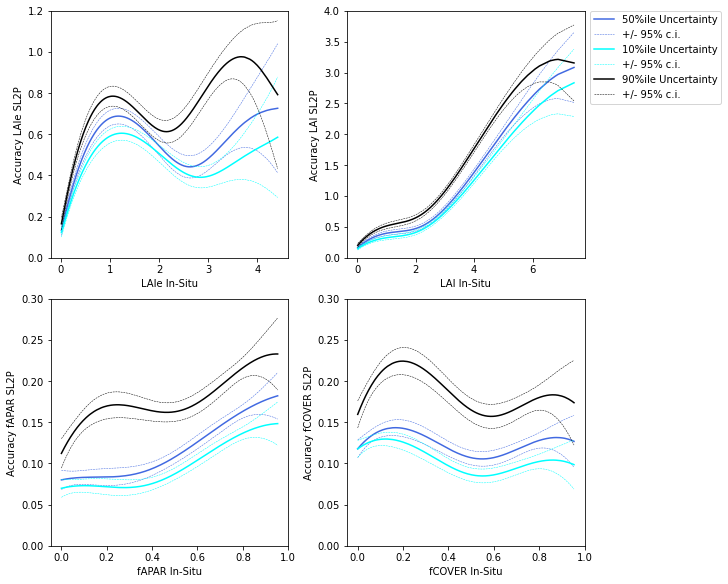

In [193]:
# figure 5


fig, ax = plt.subplots(2, 2,constrained_layout = True)
fig.set_size_inches(10, 8)

percentileToPlot = 4

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[0,0],3,'royalblue','50%ile Uncertainty')
uarLAIelow= np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size
ax[0,0].set_ylim([0,1.2])
ax[0,0].set_ylabel('Accuracy LAIe SL2P')
ax[0,0].set_xlabel('LAIe In-Situ')

#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[0,1],3,'royalblue','50%ile Uncertainty')
uarLAIlow = np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size
ax[0,1].set_ylim([0,4])
ax[0,1].set_ylabel('Accuracy LAI SL2P')
ax[0,1].set_xlabel('LAI In-Situ')


#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])
data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])
y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[1,0],3,'royalblue','50%ile Uncertainty')
uarfAPARlow = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size
ax[1,0].set_ylim([0,.3])
ax[1,0].set_ylabel('Accuracy fAPAR SL2P')
ax[1,0].set_xlabel('fAPAR In-Situ')

#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[1,1],3,'royalblue','50%ile Uncertainty')
ax[1,1].set_ylim([0,.3])
ax[1,1].set_ylabel('Accuracy fCOVER SL2P')
ax[1,1].set_xlabel('fCOVER In-Situ')


percentileToPlot = 1

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[0,0],3,'aqua','10%ile Uncertainty')
uarLAIelow= np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[0,1],3,'aqua','10%ile Uncertainty')
uarLAIlow = np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])
data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])
y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[1,0],3,'aqua','10%ile Uncertainty')
uarfAPARlow = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size

#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[1,1],3,'aqua','10%ile Uncertainty')

percentileToPlot = 9

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[0,0],3,'black','90%ile Uncertainty')
uarLAIehigh= np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[0,1],3,'black','90%ile Uncertainty')
uarLAIhigh = np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])
data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])

y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[1,0],3,'black','90%ile Uncertainty')
uarfAPARhigh = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size

#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
plotUncertainty(x,y,err,ax[1,1],3,'black','90%ile Uncertainty')
uarfCOVERhigh = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size




ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('Figure10',bbox_inches='tight')
plt.show()


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            WLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     50.61
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           1.21e-30
Time:                        21:46:34   Log-Likelihood:                -909.10
No. Observations:                1107   AIC:                             1826.
Df Residuals:                    1103   BIC:                             1846.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7726      1.200      1.477      0.1

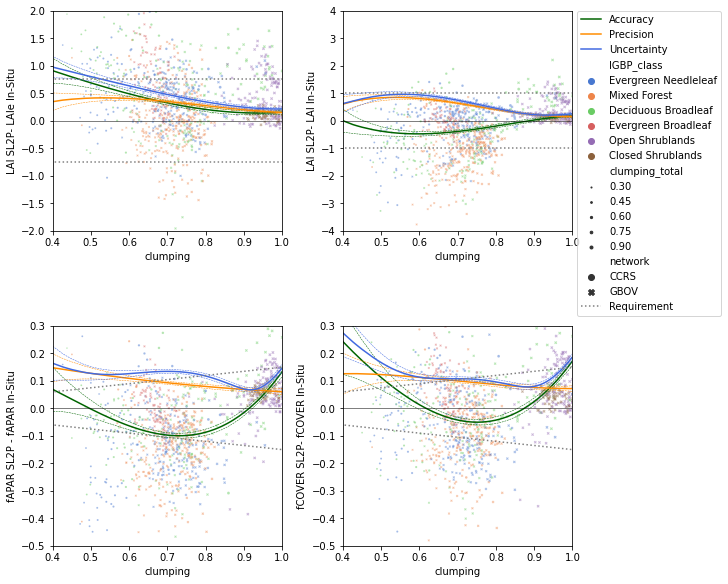

In [229]:
# figure 5


fig, ax = plt.subplots(2, 2,constrained_layout = True)
fig.set_size_inches(10, 8)

percentileToPlot = 4

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values(['clumping_total'])
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['clumping_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAIe_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
plotSummaryStats(x,y,err,ax[0,0],3)
sns.scatterplot(data=data, x='clumping_total', y='LAIe_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,4,100),np.maximum(np.linspace(0,4,100)*0.2*0.75,1*0.75),color='grey',linestyle='dotted')
ax[0,0].plot(np.linspace(0,4,100),np.minimum(-np.linspace(0,4,100)*0.2*0.75,-1*0.75),color='grey',linestyle='dotted')
ax[0,0].axhline(y=0,color='black',linewidth=0.5)
ax[0,0].set_ylim([-2,2])
ax[0,0].set_xlim([0.4,1])
ax[0,0].set_ylabel('LAI SL2P- LAIe In-Situ')
ax[0,0].set_xlabel('clumping')
uarLAIemid = np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values(['clumping_total'])
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['clumping_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
plotSummaryStats(x,y,err,ax[0,1],3)
sns.scatterplot(data=data, x='clumping_total', y='LAI_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[0,1],legend=True)
ax[0,1].plot(np.linspace(0,7,100),np.maximum(np.linspace(0,7,100)*0.2,1),color='grey',linestyle='dotted',label='Requirement')
ax[0,1].plot(np.linspace(0,7,100),np.minimum(-np.linspace(0,7,100)*0.2,-1),color='grey',linestyle='dotted')
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax[0,1].axhline(y=0,color='black',linewidth=0.5)
ax[0,1].set_ylim([-4,4])
ax[0,1].set_xlim([0.4,1])
ax[0,1].set_ylabel('LAI SL2P- LAI In-Situ')
ax[0,1].set_xlabel('clumping')
uarLAImid = np.sum(np.abs(y)<np.maximum(x*0.2,1))/y.size

#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])


data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['clumping_total'])

y = np.array(data['fAPAR_residual'])
x = np.array(data['clumping_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
print(data[data['fAPAR_total_err'].isnull()]['WAItoPAIratio_std'])
plotSummaryStats(x,y,err,ax[1,0],3)
sns.scatterplot(data=data, x='clumping_total', y='fAPAR_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,1,100),np.maximum(np.linspace(0,1,100)*0.15,0.05),color='grey',linestyle='dotted')
ax[1,0].plot(np.linspace(0,1,100),np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='grey',linestyle='dotted')
ax[1,0].axhline(y=0,color='black',linewidth=0.5)
ax[1,0].set_ylim([-0.5,0.3])
ax[1,0].set_xlim([0.4,1])
ax[1,0].set_ylabel('fAPAR SL2P - fAPAR In-Situ')
ax[1,0].set_xlabel('clumping')
uarfAPARmid = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size

#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['clumping_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['clumping_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
plotSummaryStats(x,y,err,ax[1,1],3)

sns.scatterplot(data=data, x='clumping_total', y='fCOVER_residual', hue='IGBP_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,1,100),np.maximum(np.linspace(0,1,100)*0.15,0.05),color='grey',linestyle='dotted')
ax[1,1].plot(np.linspace(0,1,100),np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='grey',linestyle='dotted')
ax[1,1].axhline(y=0,color='black',linewidth=0.5)
ax[1,1].set_ylim([-0.5,0.3])
ax[1,1].set_xlim([0.4,1])
ax[1,1].set_ylabel('fCOVER SL2P- fCOVER In-Situ')
ax[1,1].set_xlabel('clumping')
uarfCOVERmid = np.sum(np.abs(y)<np.maximum(x*0.15,0.05))/y.size
plt.savefig('Figure812png',bbox_inches='tight')

In [212]:
samplesDF = samplesList[4]
# summary stats of in-situ data includ those with no match ups and then keep only those wioth matchups
# print('Total in-situ samples per network:',samplesDF.groupby('network').count()['numSamples'])
print('Total in-situ samples per site:',samplesDF.groupby('Site').count()['numSamples'])
#print('Total in-situ samples per site:',samplesDF.groupby('Site').first()['network'])
varName = 'PLOT_ID'
#print('Total in-situ samples per site:',(samplesDF.groupby('Site')[varName].unique()))



# # summary stats for ESUs with match ups 
#samplesDF = samplesDF.loc[samplesDF['numValid']>0].replace(-999, 0)
print('Total in-situ samples per network:',samplesDF.groupby('network').count()['numSamples'])
# # print('Total in-situ samples per site:',samplesDF.groupby('Site').first()['IGBP_class'])
print('Total in-situ samples per network:',samplesDF.groupby('Site')['numSamples'].median())
#print('Total in-situ samples per network:',samplesDF.groupby('Site').mean()['PAI_total'])
# print(samplesDF.groupby('Site').mean())
# # print('Total in-situ samples per network:',samplesDF.groupby('Site').mean()['percentValid'])
# # print('IGBP land cover classes:',samplesDF.groupby(['Site', 'IGBP_class']).agg({'IGBP_class': ['count']}))


Total in-situ samples per site: Site
BartlettExperimentalForest                  58
BlandyExperimentalFarm                      85
DeadLake                                    66
DisneyWildernessPreserve                    66
Geraldton2020                               55
GuanicaForest                              104
HarvardForest                               55
HayRiver2019                                28
JonesEcologicalResearchCenter               92
Jornada                                     36
Labrador2019                                 6
Merbleue2019                                 3
Moab                                        11
MtPolley2019                                 6
NovaScotia2021                              28
OakRidge                                    49
OnaquiAult                                  27
OrdwaySwisherBiologicalStation              73
PeaceRiver2019                               9
SantaRita                                   66
SmithsonianConservation

In [1044]:
list(samplesList[4])

['fAPAR_up',
 'fAPAR_down',
 'fAPAR_total',
 'fAPAR_up_err',
 'fAPAR_down_err',
 'fAPAR_total_err',
 'samplefAPAR',
 'fAPAR_fAPAR_total_estimate',
 'fAPAR_fAPAR_total_estimate_std',
 'fAPAR_fAPAR_total_err_estimate_mean',
 'fAPAR_fAPAR_total_estimate_count',
 'fCOVER_up',
 'fCOVER_down',
 'fCOVER_total',
 'fCOVER_up_err',
 'fCOVER_down_err',
 'fCOVER_total_err',
 'samplefCOVER',
 'fCOVER_fCOVER_total_estimate',
 'fCOVER_fCOVER_total_estimate_std',
 'fCOVER_fCOVER_total_err_estimate_mean',
 'fCOVER_fCOVER_total_estimate_count',
 'Camera_Down',
 'Camera_UP',
 'Daily_Integrated_Black_Sky_fAPAR_Total',
 'Date',
 'Date_Processed_Down',
 'Date_Processed_Up',
 'Elevation',
 'GBOV_Email',
 'GBOV_ID',
 'GROUND_DATA_PI',
 'GROUND_DATA_PIs_Email',
 'Grass',
 'Herbacious',
 'IGBP_class',
 'LAICEV61_Total',
 'LAICEV61std_total',
 'LAI_Miller_down',
 'LAI_Miller_down_err',
 'LAI_Miller_up',
 'LAI_Miller_up_err',
 'LAI_PAIe_total_err_estimate_mean',
 'LAI_PAIe_total_estimate',
 'LAI_PAIe_total_estima

In [1026]:
list(samplesList[1])

['fAPAR_up',
 'fAPAR_down',
 'fAPAR_total',
 'fAPAR_up_err',
 'fAPAR_down_err',
 'fAPAR_total_err',
 'samplefAPAR',
 'fAPAR_fAPAR_total_estimate',
 'fAPAR_fAPAR_total_estimate_std',
 'fAPAR_fAPAR_total_err_estimate_mean',
 'fAPAR_fAPAR_total_estimate_count',
 'fCOVER_up',
 'fCOVER_down',
 'fCOVER_total',
 'fCOVER_up_err',
 'fCOVER_down_err',
 'fCOVER_total_err',
 'samplefCOVER',
 'fCOVER_fCOVER_total_estimate',
 'fCOVER_fCOVER_total_estimate_std',
 'fCOVER_fCOVER_total_err_estimate_mean',
 'fCOVER_fCOVER_total_estimate_count',
 'Camera_Down',
 'Camera_UP',
 'Daily_Integrated_Black_Sky_fAPAR_Total',
 'Date',
 'Date_Processed_Down',
 'Date_Processed_Up',
 'Elevation',
 'GBOV_Email',
 'GBOV_ID',
 'GROUND_DATA_PI',
 'GROUND_DATA_PIs_Email',
 'Grass',
 'Herbacious',
 'IGBP_class',
 'LAICEV61_Total',
 'LAICEV61std_total',
 'LAI_Miller_down',
 'LAI_Miller_down_err',
 'LAI_Miller_up',
 'LAI_Miller_up_err',
 'LAI_PAIe_total_err_estimate_mean',
 'LAI_PAIe_total_estimate',
 'LAI_PAIe_total_estima

In [ ]:
# summary stats for ESUs with match ups 
samplesDF = samplesDF.loc[samplesDF['numValid']>0].replace(-999, 0)
# print('Total in-situ samples per network:',samplesDF.groupby('network').count()['numSamples'])
# print('Total in-situ samples per site:',samplesDF.groupby('Site').first()['IGBP_class'])
# # print('Total in-situ samples per network:',samplesDF.groupbynumValid('Site').mean()['numSamples'])
# print('Total in-situ samples per network:',samplesDF.groupby('Site').mean()['PAI_up'])
print(samplesDF.groupby('Site').mean())
# print('Total in-situ samples per network:',samplesDF.groupby('Site').mean()['percentValid'])
# print('IGBP land cover classes:',samplesDF.groupby(['Site', 'IGBP_class']).agg({'IGBP_class': ['count']}))


                                         Elevation  LAI_Miller_down  \
Site                                                                  
BartlettExperimentalForest                   232.0         0.532308   
BlandyExperimentalFarm                       183.0         1.102165   
DeadLake                                      22.0         0.544914   
DisneyWildernessPreserve                      15.0         0.245000   
Geraldton2020                                  NaN              NaN   
GuanicaForest                                143.0         0.000000   
HarvardForest                                351.0         0.408308   
JonesEcologicalResearchCenter                 44.0         0.464522   
Labrador2019                                   NaN              NaN   
Merbleue2019                                   NaN              NaN   
Moab                                        1767.0         0.000483   
MtPolley2019                                   NaN              NaN   
NiwotR

In [ ]:
# hisytograme of samples as function of percentile
samplesList[1]['

In [ ]:
siteDF.loc[siteDF['geeFeatureCollection'].str.contains("CCRS"),'network'] = 'CCRS'
siteDF.loc[siteDF['geeFeatureCollection'].str.contains("GBOV"),'network'] = 'GBOV'

print(siteDF['network'])

0     CCRS
1     CCRS
2     CCRS
3     CCRS
4     CCRS
5     CCRS
6     CCRS
7     CCRS
8     CCRS
9     CCRS
10    CCRS
11    CCRS
12    CCRS
13    CCRS
14    CCRS
15    CCRS
16    CCRS
17    CCRS
18    CCRS
19    CCRS
20    CCRS
21    CCRS
22    CCRS
23    CCRS
24    CCRS
25    CCRS
26    CCRS
27    CCRS
28    CCRS
Name: network, dtype: object
